# Intro
- This notebook is taking a closer look at the measurement features that were correlated with measurement 17 that was highlighted in the heatmap in the EDA

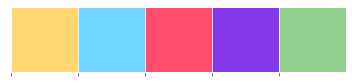

In [ ]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA

# sys.path.append("kuma_utils/")
# from kuma_utils.preprocessing.imputer import LGBMImputer

from drive.MyDrive.Kaggle_TPS_0822.src import functions

import warnings
warnings.filterwarnings("ignore")

# Loading Data
- I concat the train and test so I dont have to apply the same procedure twice, easy to split based on failure

In [ ]:
CFG = yaml.load(open('drive/MyDrive/Kaggle_TPS_0822/src/config.YAML', 'rb'))

functions.set_seed(CFG['SEED'])

pd.set_option('display.max_rows', CFG['NROWS'])
pd.set_option('display.max_columns', CFG['NCOLS'])

train = pd.read_csv(CFG['DATAPATH'] + 'train.csv', index_col='id')
test = pd.read_csv(CFG['DATAPATH'] +'test.csv', index_col='id')
train = pd.concat([train])
test = pd.concat([test])
data = pd.concat([train, test])

In [ ]:
cat_feats, int_feats, cont_feats, null_feats, no_nulls = functions.get_feats(train)
df_list = functions.get_products(train, test)

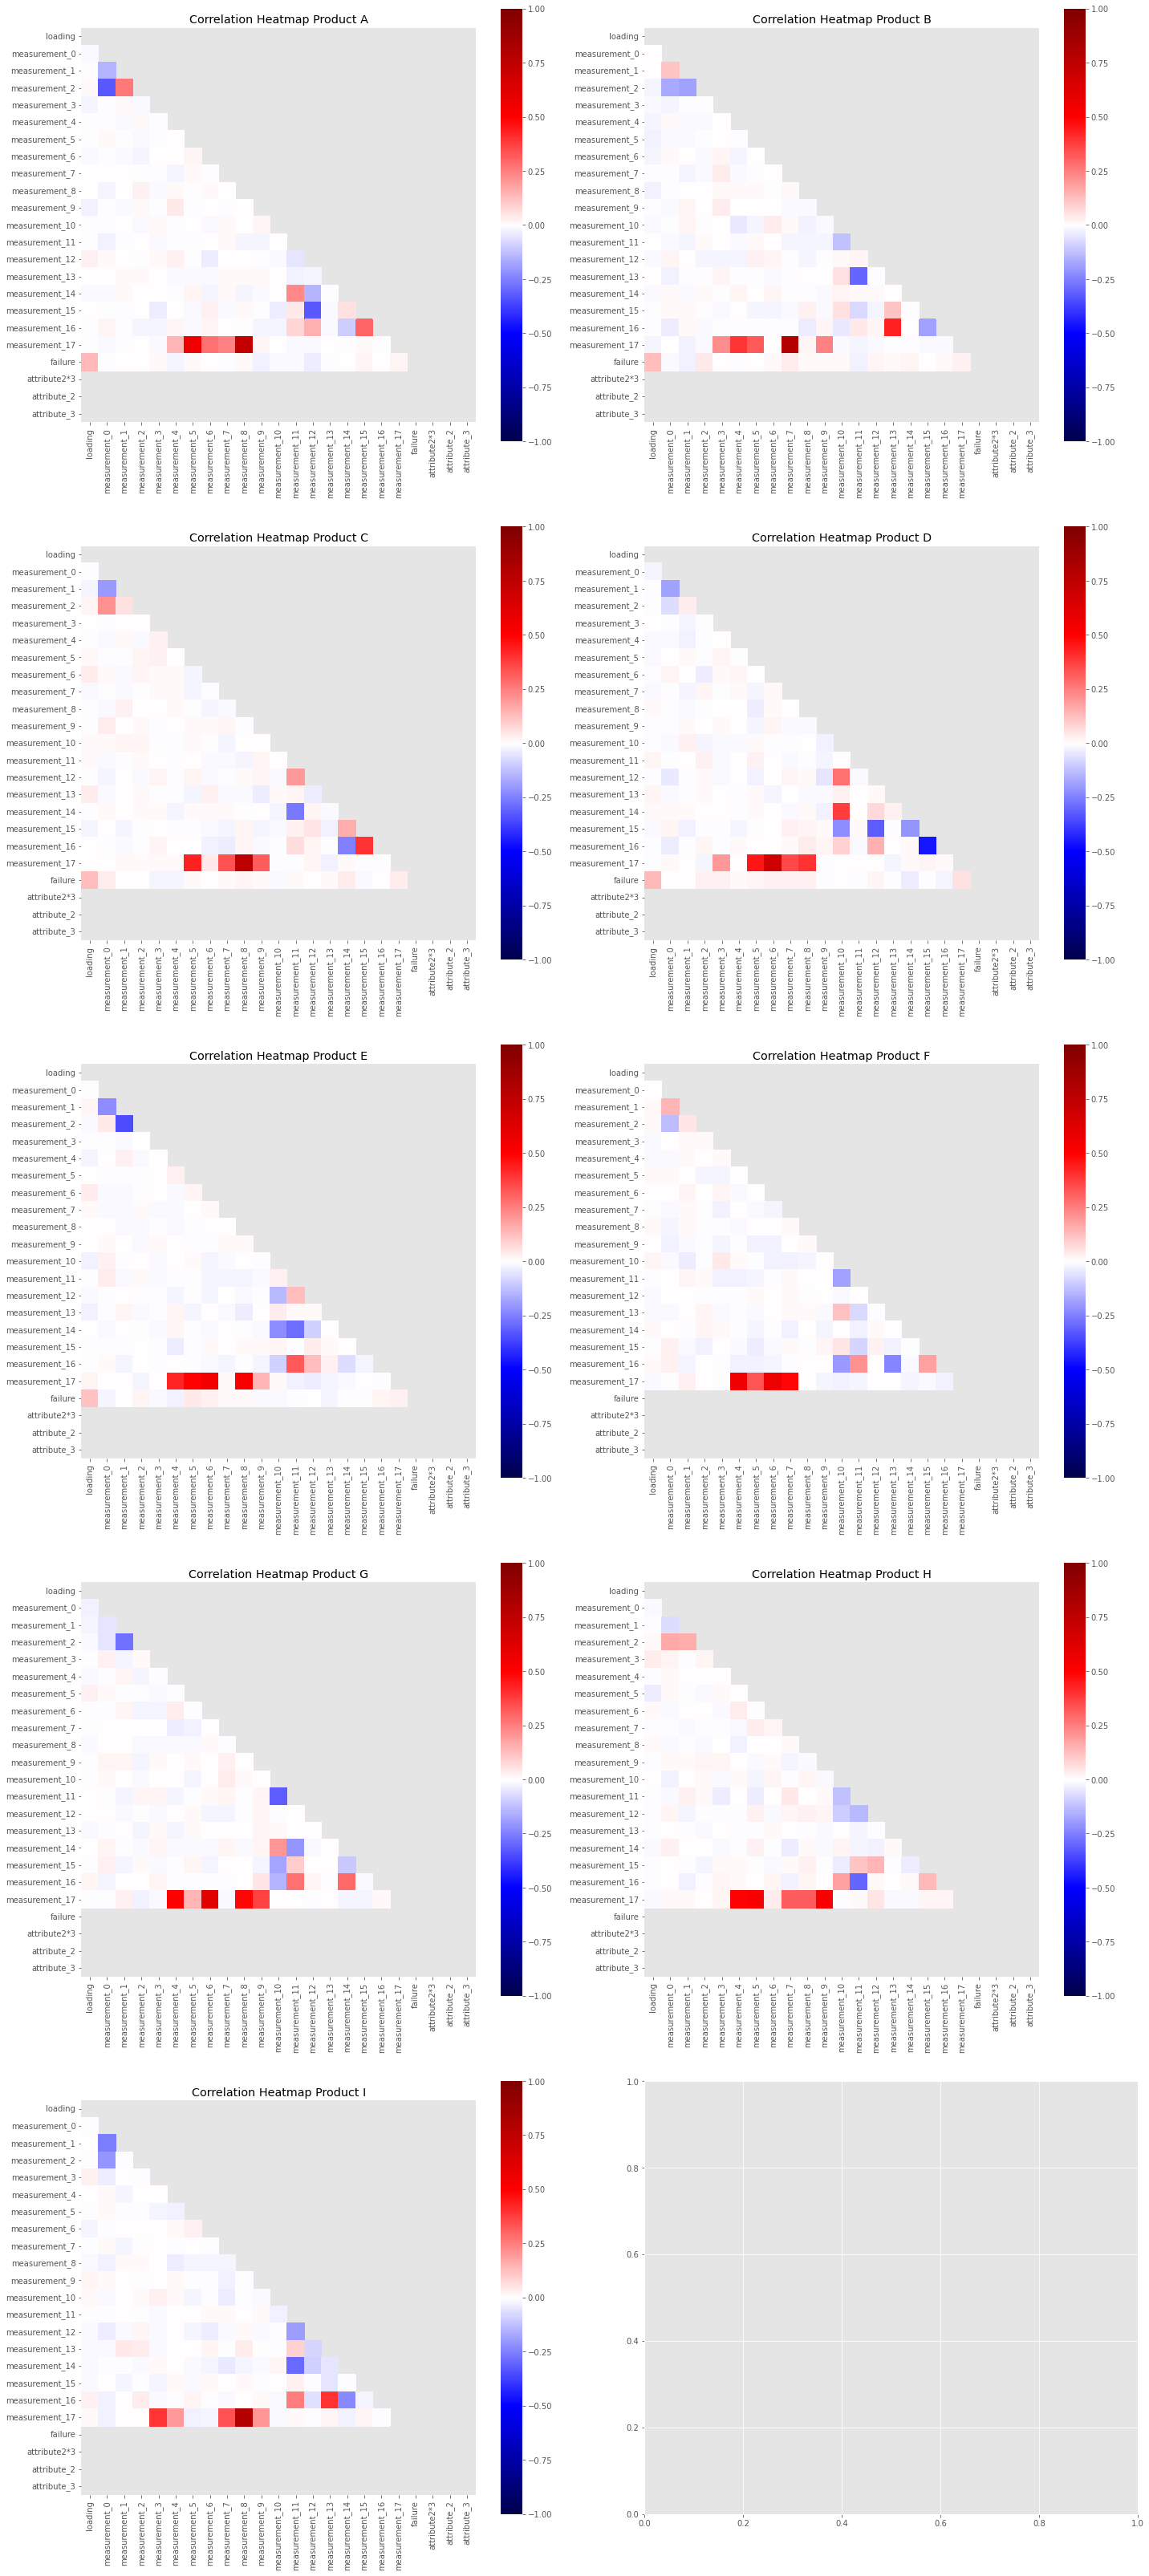

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(20,45))
for ax, df, title in zip(axes.ravel()[:len(df_list)], df_list, ["A", "B", "C", "D", "E", "F", "G", "H", "I"]):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    col_pal = sns.color_palette('seismic', as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=col_pal, square=True, vmax=1.0, vmin=-1.0, ax=ax)
    ax.set_title(f'Correlation Heatmap Product {title}')
plt.tight_layout()

- Each product code has a different array of measurements corelated with measurement 17, let's see if they are all important

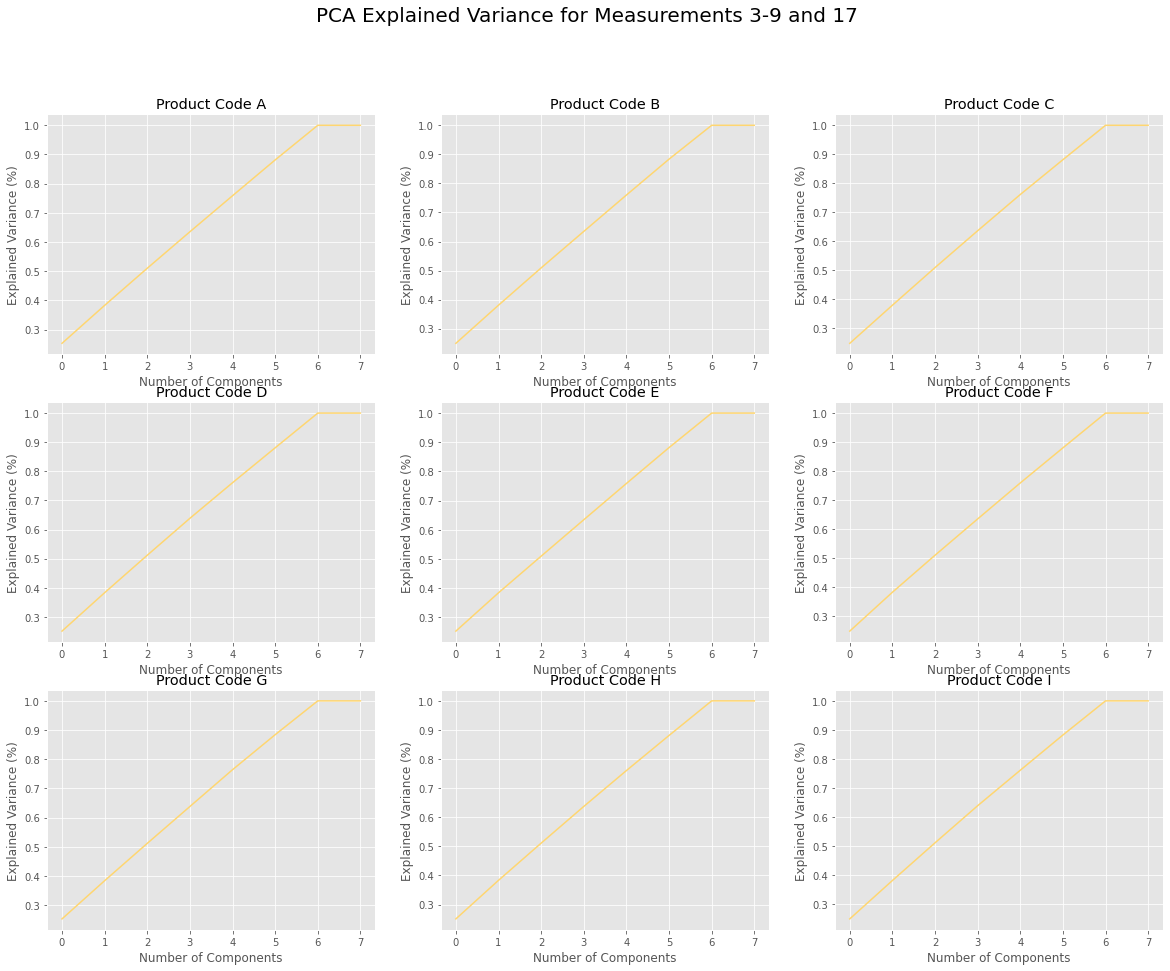

In [ ]:
pca = PCA(n_components=8)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
measurements = [f'measurement_{i}' for i in range(3, 10)]
for ax, df, title in zip(axes.ravel()[:len(df_list)], df_list, ['A', 'B', 'C', 'D', 'E', "F", "G", "H", "I"]):
    newdf = df[measurements + ['measurement_17']].dropna()
    pca.fit(StandardScaler().fit_transform(newdf))
    exvar = pca.explained_variance_ratio_
    var = np.cumsum(exvar)
    ax.plot(var)
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Explained Variance (%)')
    ax.set_title(f'Product Code {title}')

plt.suptitle('PCA Explained Variance for Measurements 3-9 and 17', fontsize=20)
plt.show()

- Nope! Only 7 out of 8 of them, according to PCA, lets check out their feature importance and R2 using Linear Regression

In [ ]:
lrr = LinearRegression()
cols = measurements+['measurement_17']
dfa = df_list[0][measurements+['measurement_17']].dropna()
X = dfa[measurements]
y = dfa['measurement_17']

lrr.fit(X, y)
lrr.score(X, y)

0.9999777207166654

In [ ]:
feat_importances = []
for df in df_list:
    dfnona = df[measurements+['measurement_17']].dropna()
    X = dfnona[measurements]
    y = dfnona['measurement_17']
    lrr.fit(X, y)
    imps = lrr.coef_
    feat_importances.append(imps)

In [ ]:
for i, product in enumerate(feat_importances, start=0):
    if i == 0:
        feat_imp_df = pd.DataFrame(product, columns=[i], index=[measurements])
    else:
        tmp = pd.DataFrame(product, columns=[i], index=[measurements])
        feat_imp_df = pd.concat([feat_imp_df, tmp], axis=1)
    

In [ ]:
feat_imp_df = feat_imp_df.T
feat_imp_df.index = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

- Two features out of each product group have coefficients of essentially 0
- Now to remove the useless ones and make a dictionary from the others to use to impute missing values!

In [ ]:
measurement_fill_dict = {}
for product in feat_imp_df.T.columns:
    highest = feat_imp_df.loc[product, :].abs().nlargest(5).index.tolist()
    measurement_fill_dict[product] = highest

In [ ]:
for prod in measurement_fill_dict.keys():
    tmp = []

    for i, cols in enumerate(measurement_fill_dict[prod]):
        tmp.append(cols[0])

    measurement_fill_dict[prod] = tmp

In [ ]:
data['measurement_3_na'], data['measurement_5_na'] = data['measurement_3'].isnull().astype(int), data['measurement_5'].isnull().astype(int)
data['area'] = data['attribute_2'] * data['attribute_3']

features = [col for col in test.columns if col.startswith('measurement') or col=='loading']

for code in measurement_fill_dict.keys():
    tmp = data[data['product_code'] == code]
    columns = ['measurement_17'] + measurement_fill_dict[code] 
    for col in columns:
        new_cols = ['measurement_17'] + measurement_fill_dict[code] 
        new_cols.remove(col)

        tmp_train = tmp[columns].dropna(how='any')
        tmp_test = tmp[(tmp[new_cols].isnull().sum(axis=1) == 0) & (tmp[col].isnull())]

        lrr = LinearRegression()
        lrr.fit(tmp_train[new_cols], tmp_train[col])

        data.loc[(data['product_code'] == code) & (data[new_cols].isnull().sum(axis=1) == 0) & (data[col].isnull()), col] = lrr.predict(tmp_test[new_cols])

    ii = IterativeImputer(LinearRegression())
    ii.fit(data.loc[data['product_code'] == code, features])
    data.loc[data['product_code'] == code, features] = ii.transform(data.loc[data['product_code'] == code, features])

- Now the dataset is all imputed, we can save it for more feature engineering/preprocessing

In [ ]:
data.to_csv(CFG['DATAPATH'] + 'imputed_data.csv', index='id')